In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from itertools import product

from skimage import io, color, exposure, transform, img_as_float32
import skimage


from dask import bag, diagnostics
from scipy import stats

from pathlib import Path
import os, sys

sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

<module 'leukopy_lib' from '/home/marie-anne/code/Leukopy/notebooks/leukopy_lib.py'>

# Import normal peripheral blood cell dataset

In [2]:
path_name = '../../data/PBC_dataset_normal_df_resize_luminance.csv'
path = Path(path_name)
df = pd.read_csv(path_name)
df.head()

,img_paths,id,label,height,width,mean_brightness,mean_luminance
0,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,225079,MO,363,360,196.225564,0.756902
1,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,582430,MO,363,360,196.672727,0.757366
2,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,436409,MO,363,360,204.348235,0.797640
3,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,648815,MO,363,360,199.038259,0.770929
4,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,668574,MO,363,360,191.020018,0.734784


In [3]:
classes = df['label'].unique()
classes

array(['MO', 'ERB', 'PLATELET', 'BA', 'IG', 'SNE', 'LY', 'EO'],
      dtype=object)

In [4]:
df.groupby(['height', 'width']).size()

height  width
360     359          1
        360        198
        361          1
        362          1
361     360          2
363     360      16639
369     366        250
dtype: int64

In [5]:
sizes = df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.hvplot.scatter(x='height', y='width', size='count', 
                     xlim=(355,370), ylim=(355,370), 
                     grid=True, 
                     height=500, width=600).options(line_alpha=0.7,
                                                    line_width=2,
                                                    fill_alpha=0.04)


:Scatter   [height]   (width,count)

## Import images and store as an array of arrays

In [20]:
dfile_bag = bag.from_sequence(df.img_paths.to_list()).map(leuko.load_image, as_grey=True)

In [21]:
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())


[########################################] | 100% Completed |  1min 36.3s


In [22]:
type(images)

numpy.ndarray

In [24]:
pd.Series([im.shape for im in images]).unique()

array([(363, 360)], dtype=object)

In [83]:
len(images)

17092

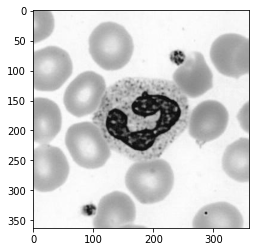

In [23]:
i = np.random.randint(0,len(df))
plt.imshow(images[i], cmap='gray')

# Analysis of brightness/luminance

In [25]:
def plot_gray(idx, plot_gray=False):
    
    gray = images[idx]
    histo, histo_centers = exposure.histogram(gray)
    
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

    if plot_gray:
        ax[0].imshow(gray, cmap='gray')
    else: ax[0].imshow(im)

    ax[1].plot(histo_centers, histo, lw=2)
    ax[1].set_title('Gray-level histogram')
    plt.xlim([0, 1])

    plt.suptitle(df.loc[idx]['label'])
    plt.tight_layout()
    plt.show()
    return gray, histo, histo_centers, fig

In [26]:
def plot_on_grid(image_arr, df, rand=None):
    
    if rand is None:
        rand = np.random.choice(np.arange(image_arr.shape[0]), size = 12)

    fig = plt.figure(figsize=(20, 8))
    outer_grid = fig.add_gridspec(3, 4, wspace=0.3, hspace=0.5)

    for idx, coord in zip(rand, [p for p in product(range(3), range(4))]):
        
        inner_grid = outer_grid[coord].subgridspec(1, 2, wspace=0.5, hspace=0.2)
        ax = inner_grid.subplots()  
        gray = image_arr[idx]
        
        histo, histo_centers = exposure.histogram(gray)
        ax[0].imshow(image_arr[idx], cmap='gray')
        lab = df.loc[idx]['label']
        ax[0].set_title(f'{idx} - {lab}', fontweight='bold')

        ax[1].plot(histo_centers, histo, lw=2)
        ax[1].set_xlim([0, 1])
        lum = df.loc[idx]['mean_luminance']
        ax[1].set_title(f'mean_lum = {lum:.2g}', fontweight='bold')

            
    for ax in fig.get_axes():
        ss = ax.get_subplotspec()
        ax.spines.top.set_visible(ss.is_first_row())
        ax.spines.bottom.set_visible(ss.is_last_row())
        ax.spines.left.set_visible(ss.is_first_col())
        ax.spines.right.set_visible(ss.is_last_col())
        
    plt.show()       
    return fig

Here is an example of gray value analysis

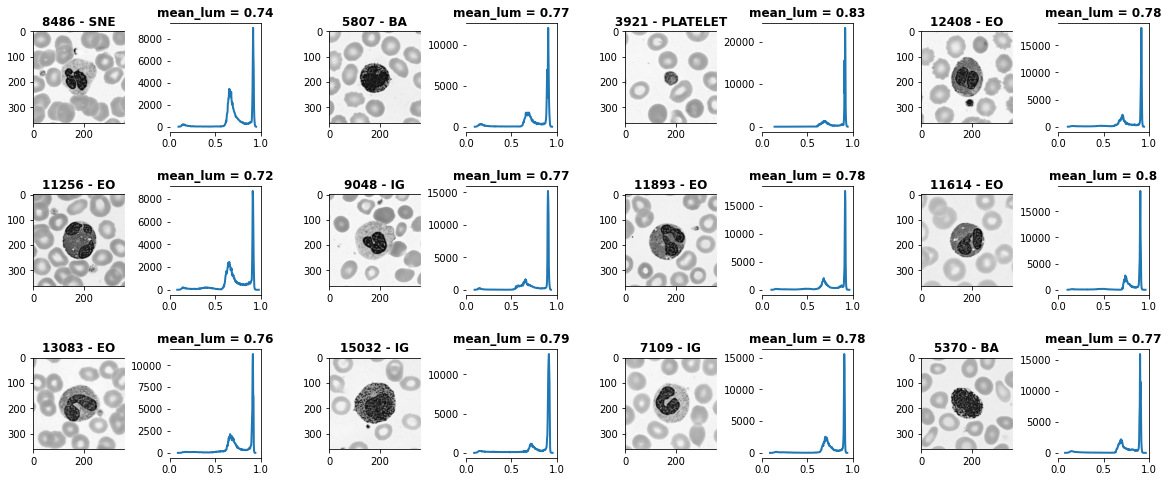

In [33]:
rand_grid_gray = plot_on_grid(images, df)

## Mean luminance calcul

In [66]:
# df['mean_luminance'] = [np.mean(im) for im in images]
# df.to_csv('../../data/PBC_dataset_normal_df_resize_luminance.csv', index=False)

<AxesSubplot:xlabel='mean_luminance', ylabel='Density'>

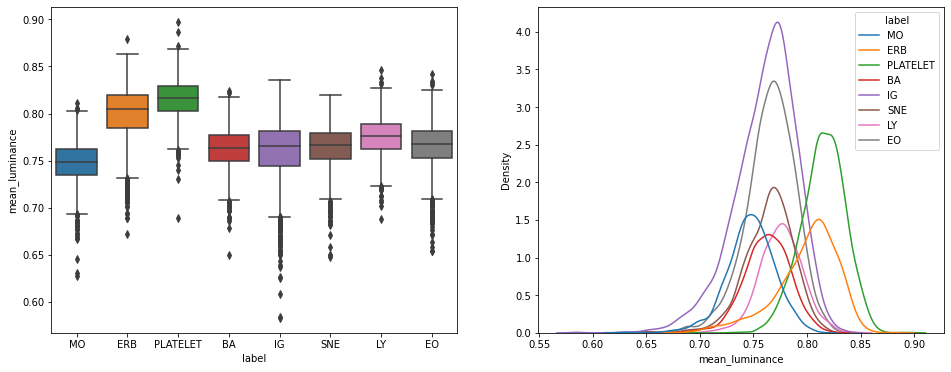

In [28]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
sns.boxplot(x = "label", y = "mean_luminance", data = df)

plt.subplot(1,2,2)
sns.kdeplot(x = "mean_luminance", hue = "label", data = df)

Let's look at the two most extreme outliers

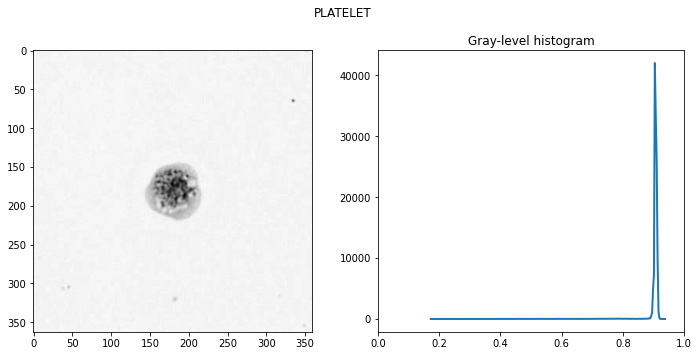

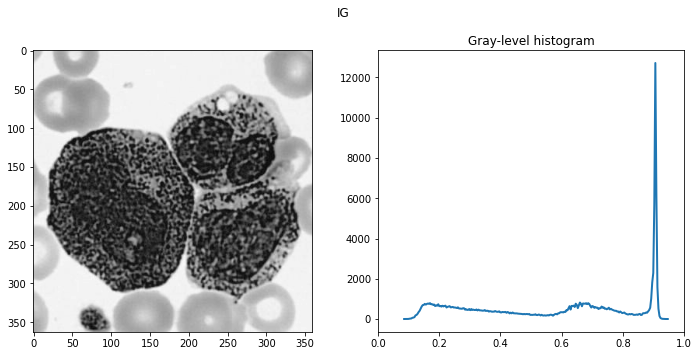

In [29]:
gray_test, histo, histo_centers, fig = plot_gray(df.mean_luminance.argmax(), plot_gray=True) 
gray_test, histo, histo_centers, fig = plot_gray(df.mean_luminance.argmin(), plot_gray=True) 

In [30]:
def plot_on_grid_by_cell(label, outliers=False):
    temp_df =  df[df.label == label]
    if outliers:
        temp_df = temp_df[np.abs(stats.zscore(temp_df.mean_luminance)) > 3]
    display(temp_df)
        
    temp_images = images[temp_df.index]
    
    temp_df = temp_df.reset_index(drop=True)
    mean_exp = np.array([exposure.histogram(im) for im in temp_images])   
    
    plot_on_grid(temp_images, temp_df)

    return fig

,img_paths,id,label,height,width,mean_brightness,mean_luminance
3680,../../data/PBC_dataset_normal_DIB/platelet/PLA...,466299,PLATELET,363,360,225.960152,0.897709
4311,../../data/PBC_dataset_normal_DIB/platelet/PLA...,821680,PLATELET,363,360,223.795483,0.886937
4360,../../data/PBC_dataset_normal_DIB/platelet/PLA...,542376,PLATELET,363,360,188.920355,0.730380
4387,../../data/PBC_dataset_normal_DIB/platelet/PLA...,321899,PLATELET,363,360,180.589978,0.689188
4395,../../data/PBC_dataset_normal_DIB/platelet/PLA...,963675,PLATELET,363,360,192.839769,0.745138
4469,../../data/PBC_dataset_normal_DIB/platelet/PLA...,705601,PLATELET,363,360,195.422100,0.753109
4959,../../data/PBC_dataset_normal_DIB/platelet/PLA...,636919,PLATELET,363,360,190.958351,0.740011


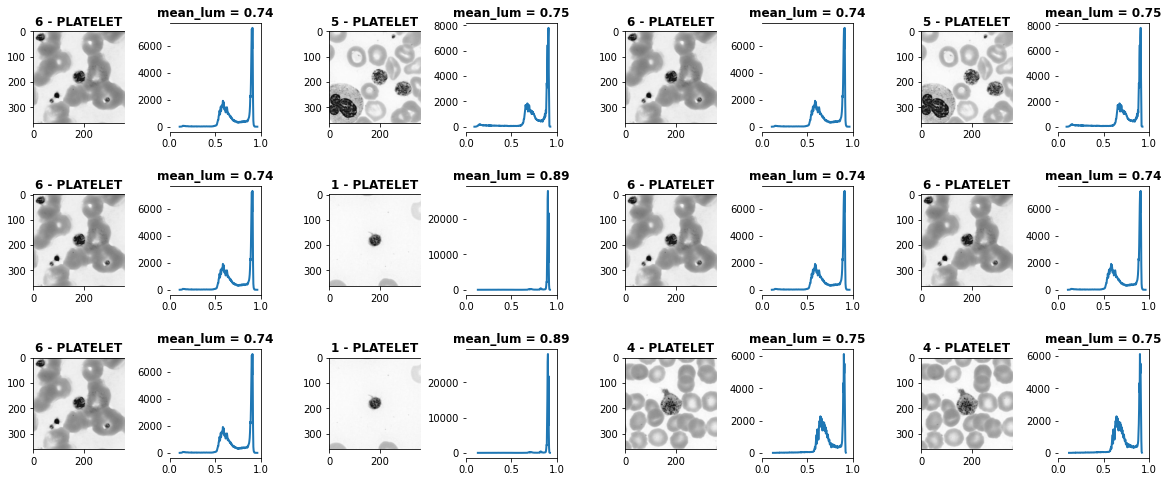

In [31]:
mo_grid = plot_on_grid_by_cell('PLATELET', outliers=True)

,img_paths,id,label,height,width,mean_brightness,mean_luminance
5399,../../data/PBC_dataset_normal_DIB/basophil/BA_...,218293,BA,363,360,178.158037,0.678265
5484,../../data/PBC_dataset_normal_DIB/basophil/BA_...,8742,BA,363,360,181.311881,0.689916
5710,../../data/PBC_dataset_normal_DIB/basophil/BA_...,659962,BA,363,360,184.086823,0.697011
5938,../../data/PBC_dataset_normal_DIB/basophil/BA_...,178853,BA,363,360,180.685522,0.685871
6157,../../data/PBC_dataset_normal_DIB/basophil/BA_...,953133,BA,363,360,180.948467,0.690308
6272,../../data/PBC_dataset_normal_DIB/basophil/BA_...,936027,BA,363,360,181.802773,0.687906
6329,../../data/PBC_dataset_normal_DIB/basophil/BA_...,107595,BA,363,360,183.300301,0.696388
6375,../../data/PBC_dataset_normal_DIB/basophil/BA_...,208484,BA,363,360,173.974770,0.649241
6412,../../data/PBC_dataset_normal_DIB/basophil/BA_...,674430,BA,363,360,182.246202,0.696583


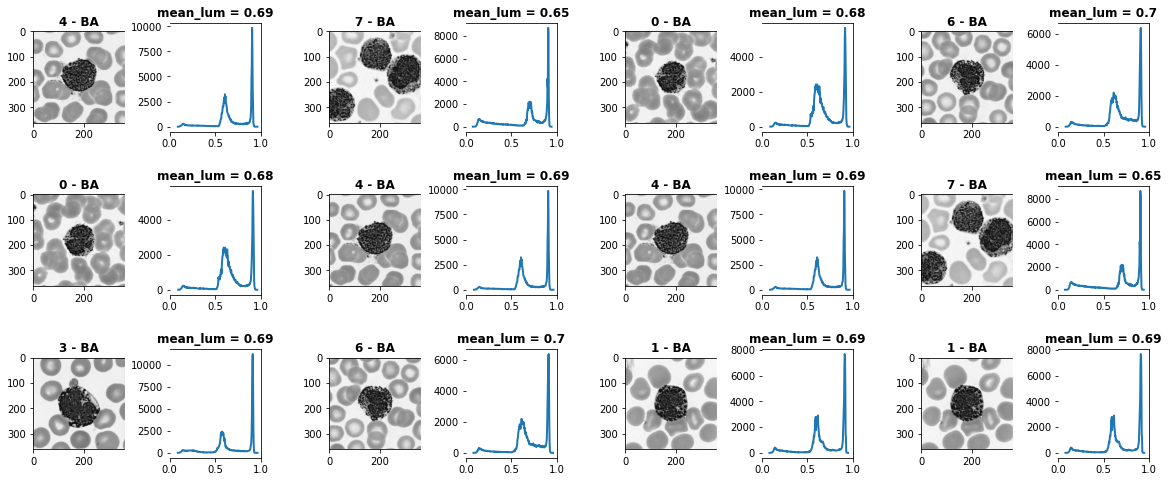

In [401]:
mo_grid = plot_on_grid_by_cell('BA', outliers=True)

,img_paths,id,label,height,width,mean_brightness,mean_luminance
0,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,225079,MO,363,360,196.225564,0.756902
1,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,582430,MO,363,360,196.672727,0.757366
2,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,436409,MO,363,360,204.348235,0.797640
3,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,648815,MO,363,360,199.038259,0.770929
4,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,668574,MO,363,360,191.020018,0.734784
...,...,...,...,...,...,...,...
1415,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,245512,MO,363,360,200.310986,0.778538
1416,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,218905,MO,363,360,194.379367,0.748778
1417,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,727663,MO,369,366,200.938785,0.756132
1418,../../data/PBC_dataset_normal_DIB/monocyte/MO_...,149181,MO,363,360,191.657017,0.738558


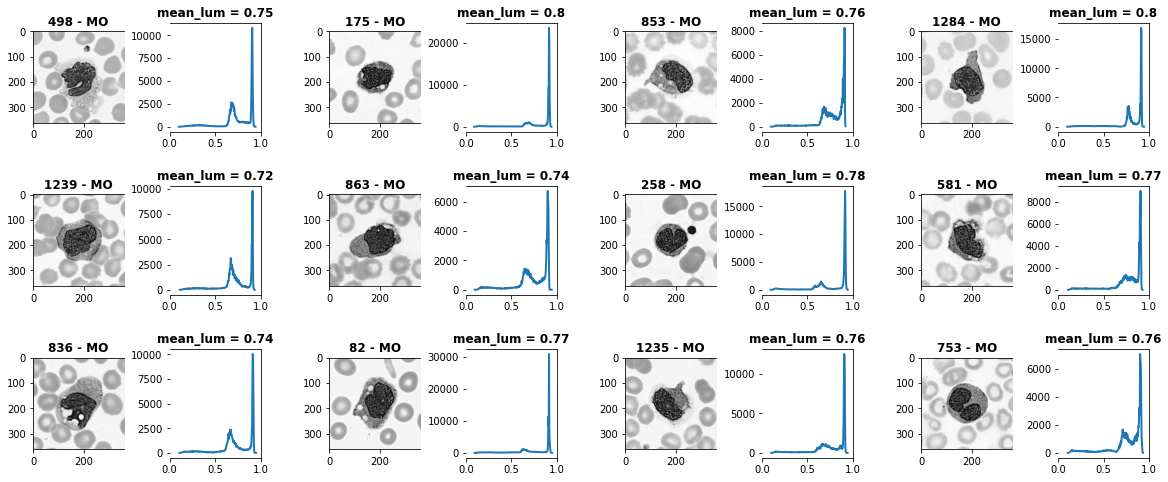

In [400]:
mo_grid = plot_on_grid_by_cell('MO')

## Mean gray per cell

In [109]:
def plot_mean_gray_per_cell(label):
    
    temp_df =  df[df.label == label]
    
    temp_images = images[temp_df.index]
    mean_exp = np.array([exposure.histogram(im) for im in temp_images])   
   
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

    
    ax[0].imshow(temp_images.mean(axis=0), cmap='cividis_r')

    ax[1].plot(mean_exp.mean(axis=0)[1], mean_exp.mean(axis=0)[0])
    ax[1].set_title('Gray-level histogram')
    plt.xlim([0, 1])

    plt.suptitle(f'mean gray value for {label}')
    plt.tight_layout()
    plt.show()
    return mean_exp

#TO DO include sd

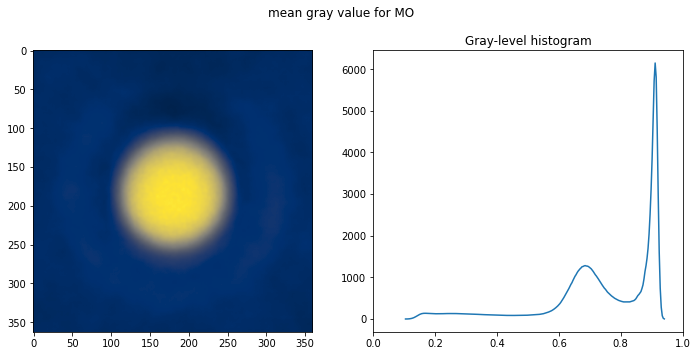

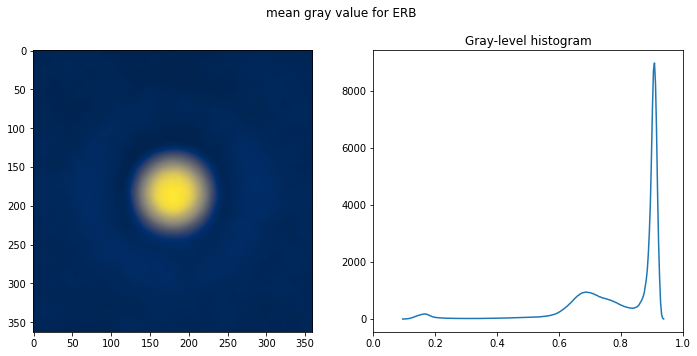

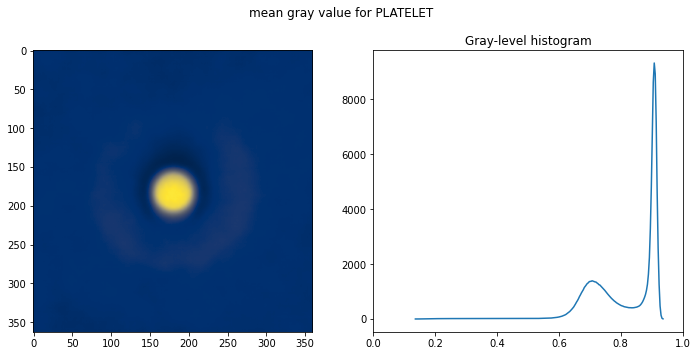

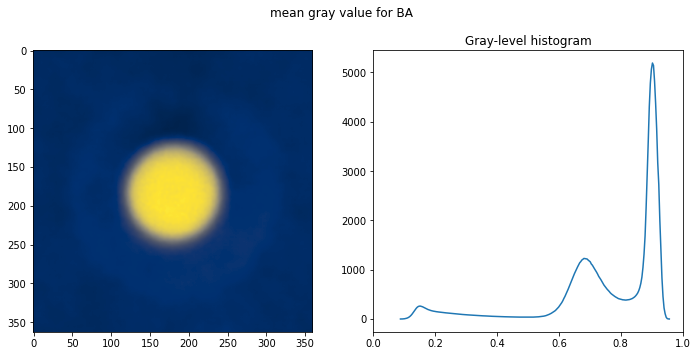

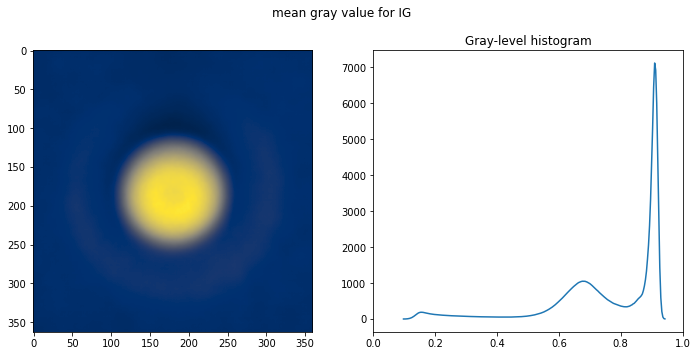

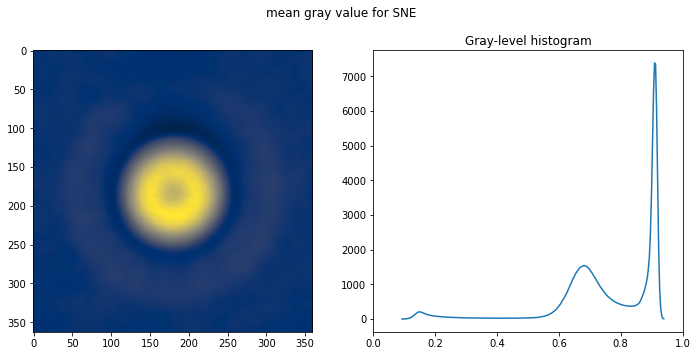

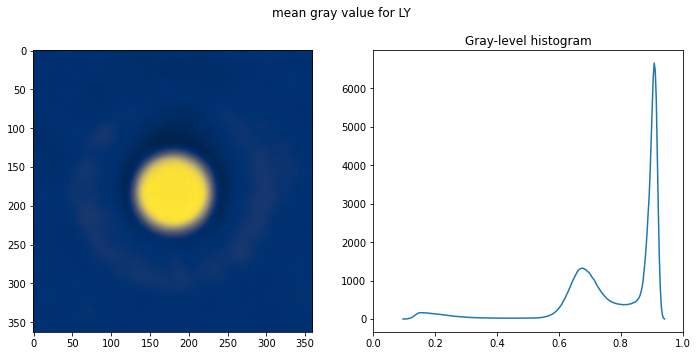

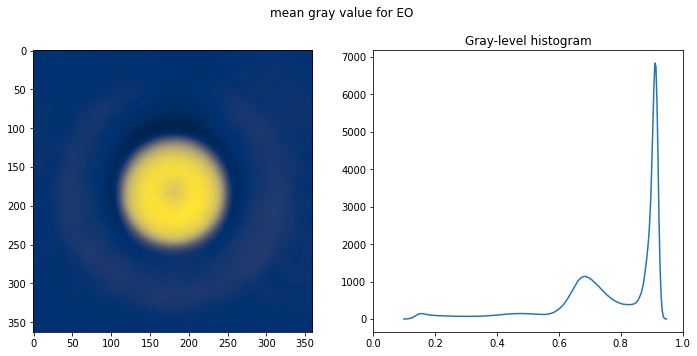

In [110]:
for cell in df.label.unique():
    plot_mean_gray_per_cell(cell)

In [156]:
stats_by_cell = df.groupby(['label']).agg(mean=('mean_luminance', 'mean'),
                          std=('mean_luminance', 'std'),
                          q25=('mean_luminance',lambda x:  x.quantile(0.25)),
                          q75=('mean_luminance',lambda x:  x.quantile(0.75)),
                          iqr=('mean_luminance',lambda x:  x.quantile(0.75) - x.quantile(0.25)),
                         )

In [157]:
stats_by_cell

,mean,std,q25,q75,iqr
label,,,,,
BA,0.762601,0.021408,0.749489,0.777427,0.027938
EO,0.766007,0.023300,0.752767,0.781742,0.028975
ERB,0.799492,0.029422,0.784390,0.819605,0.035215
IG,0.761312,0.029044,0.744704,0.781103,0.036399
LY,0.775679,0.020046,0.762621,0.788975,0.026354
MO,0.747343,0.022512,0.734406,0.761987,0.027581
PLATELET,0.815008,0.020388,0.802172,0.829084,0.026912
SNE,0.764743,0.022507,0.751410,0.779772,0.028362
